# TensorFlow and Neural Networks

## Introductory Tensorflow

### Jack Bennetto

#### March 7, 2017


## Objectives

* Use TensorFlow to do calculations.
* Explain the advantages and disadvantages of neural networks.
* Explain the basic neural-network algorithms.
* Build a simple neural network in TensorFlow.

## TensorFlow

TensorFlow is a Google technology primarily designed to build neural networks. It's not just for neural networks – it can be used for other things as well – but that's the focus. This morning we'll learn about the basics of TensorFlow itself, and this afternoon we'll see how it's used for neural networks. Tomorrow we'll use it to build convolutional neural networks to process images.

The main object in TensorFlow is a **tensor**, which in this context is mostly just an array that may have any number of dimensions.

The first point to make is that computation in TensorFlow doesn't happen right away. First we build a **graph** that descibes the computation, and then we execute it. Let's start by building a simple graph to solve some simple linear algebra.

$$\begin{bmatrix}
3 & 3
\end{bmatrix} \cdot
\left(
\begin{bmatrix}
4 \\
5
\end{bmatrix}
+
\begin{bmatrix}
2 \\
2
\end{bmatrix}
\right)
$$

What's this equal to?

In [1]:
import tensorflow as tf
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
matrix1 = tf.constant([[3., 3]])
matrix2 = tf.constant([[4.], [5]])
matrix3 = tf.constant([[2.], [2]])

total = tf.add(matrix2, matrix3)
product = tf.matmul(matrix1, total)

A **constant** is what it sounds like: an object that doesn't change. Let's look a bit at what we have. First we'll look at the types and print out the objects themselves.

In [3]:
print type(matrix1)
print type(product)
print matrix1
print product

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Const:0", shape=(1, 2), dtype=float32)
Tensor("MatMul:0", shape=(1, 1), dtype=float32)


**Question:** What's float32? Is that the same default as a float in numpy?

In [4]:
np.array(1.).dtype

dtype('float64')

Ok, so they are all tensors. (Note that at this point no computation has been done and we don't have a result yet) As in numpy we can look at the shape of a tensor; getting these wrong is a frequent source of error.

In [5]:
print matrix1.get_shape()
print matrix2.get_shape()
print matrix3.get_shape()
print total.get_shape()
print product.get_shape()

(1, 2)
(2, 1)
(2, 1)
(2, 1)
(1, 1)


All this checks out. Note they are actually returning special objects, not just tuples.

In [6]:
print repr(matrix1.get_shape())

TensorShape([Dimension(1), Dimension(2)])


To actually do anything with that we need to create a **session**. A session is a bit like a context in Spark; all TensorFlow computation happens within it. Running a tensor within a session evaluates in as a numpy array.

In [7]:
sess = tf.Session()

In [8]:
sess.run(product)

array([[ 39.]], dtype=float32)

If we don't want to worry about the session object all the time, we can create an **interactive session**. That installs it as the default session so we can evaluate an object directly. We'll use an interactive session from now on, but you might not always use one.

In [124]:
tf.InteractiveSession()

In [125]:
product.eval()

array([[ 39.]], dtype=float32)

Some nodes don't have an `eval` method. For those (if we're using an interactive session and don't want to use the session object) we use the `run` method instead.

**Practice:** Multiply

$$\begin{bmatrix}
1 \\
1
\end{bmatrix} \cdot
\begin{bmatrix}
1 & 1
\end{bmatrix}
$$


in tensorflow, without cutting-and-pasting, ideally without looking.

In [126]:
m1 = tf.constant([[1],[1]])
m2 = tf.constant([[1,1]])
tf.matmul(m1, m2).eval()
(m1+m2).eval()

array([[2, 2],
       [2, 2]], dtype=int32)

You can create a matrix filled with zeros (or ones) with `tf.zeros` (or `tf.ones`) that work the same as in numpy. Or you can create them with `tf.constant` from numpy arrays.

**Experiment:** Use `tf.zeros` to figure out tensorflow broadcasting rules. Are they the same as numpy?

In [127]:
tf.zeros((3,2)).eval()

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]], dtype=float32)

In [128]:
x1 = tf.zeros((3,2,1))
x2 = tf.zeros((3,1,2))
print x1.get_shape()
print x2.get_shape()
print (x1+x2).eval()


(3, 2, 1)
(3, 1, 2)
[[[ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]]]


## Feeds and placeholders

**Placeholders** are tensors that don't have a specified value, but one that is filled in later with a **feed**. For example, suppose you want to build a graph that will multiply two numbers.

In [129]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)
output = tf.multiply(input1, input2)

To evaluate the output we need to provide a feed.

In [130]:
output.eval(feed_dict={input1:6, input2:7})

42.0

Note this is the same as doing this.

In [131]:
sess.run(output, feed_dict={input1:6, input2:7})

42.0

Note that this could take an array as well.

In [132]:
output.eval(feed_dict={input1:[6], input2:[4,5]})

array([ 24.,  30.], dtype=float32)

That's because we didn't specify any input dimensions. It's good to specify the input shape if we know it (in the interests of our own mental health) but we frequently leave one dimension as `None` when we're doing batch jobs so we can vary the size of the batch.

In [109]:
input1 = tf.placeholder(tf.float32, shape=(3,))
input2 = tf.placeholder(tf.float32, shape=(None,))
output = tf.mul(input1, input2)

In [110]:
output.eval(feed_dict={input1:[1,2], input2:[5,5,5]})

ValueError: Cannot feed value of shape (2,) for Tensor u'Placeholder_12:0', which has shape '(3,)'

In [111]:
output.eval(feed_dict={input1:[2,3], input2:[5,5]})

ValueError: Cannot feed value of shape (2,) for Tensor u'Placeholder_12:0', which has shape '(3,)'

In [112]:
output.eval(feed_dict={input1:[2,3,3], input2:[5,5,5]})

array([ 10.,  15.,  15.], dtype=float32)

See why it's good to specify dimensions?

## Variables

Much of tensorflow followed a functional-programming model, but variables go around that.

Variables are tensors that might change values instead of just having a single value once evaluated. These are used (for example) to represent the strength of a connection in a network. They have an initial value; you have to run a special function (`global_variables_initializer()`) to initialize them.

## Solving an Optimization Problem

Let's solve a simple optimization problem. We want to find the minimum of a function, but it's been a few years since we've had calculus and forgot how to take a derivative.

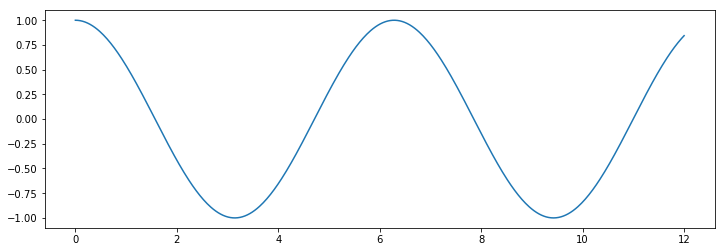

In [113]:
xpts = np.linspace(0, 12, 500)
ypts = np.cos(xpts)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(xpts, ypts)

In [11]:
sess = tf.InteractiveSession()

In [12]:
x = tf.Variable(1.0, dtype=tf.float64)
y = tf.cos(x)

To solve this we create an optimizer object (there are a bunch of different types) and use that to create a minimize operation that, when run, will (incrementally) minimize its loss. Running the operation does two things, first computes the gradients of the loss with respect to the variables in the graph, and then applies the gradients to the variables.

In [14]:
optimizer = tf.train.AdamOptimizer(1.0)
train = optimizer.minimize(y)
tf.global_variables_initializer().run()
for i in xrange(800):
    if i%50 == 0:
        print "x = {0:.16f}  y = {1:.12f}".format(x.eval(), y.eval())
    train.run()

x = 1.0000000000000000  y = 0.540302305868
x = 3.0507135606807179  y = -0.995873336589
x = 3.1387123596689324  y = -0.999995851956
x = 3.1417508280952875  y = -0.999999987490
x = 3.1416123003443959  y = -0.999999999807
x = 3.1415913599869900  y = -0.999999999999
x = 3.1415927104670001  y = -1.000000000000
x = 3.1415926362379665  y = -1.000000000000
x = 3.1415926547248301  y = -1.000000000000
x = 3.1415926536847896  y = -1.000000000000
x = 3.1415926535903167  y = -1.000000000000
x = 3.1415926535898420  y = -1.000000000000
x = 3.1415926535897607  y = -1.000000000000
x = 3.1415926535897913  y = -1.000000000000
x = 3.1415926535897936  y = -1.000000000000
x = 3.1415926535897936  y = -1.000000000000
